In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import IPython as ip
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# use the r to read the csv file from the desktop using the path
# the compressed zip folder works in this situation. It may be because
# it is the only file inside the compressed zip folder

df = pd.read_csv(r"C:\Users\skhou\Desktop\US_Accidents_June20.csv (1).zip")
# df_save = df

# Describes all of the column data types
# df.head()
# df.dtypes
# df.info()

In [3]:
df['Severity'].value_counts()

2    2373210
3     998913
4     112320
1      29174
Name: Severity, dtype: int64

# Identify the columns with Null or NA values
df.isnull() gives T/F values for each element in df
adding .sum() gives the totals of values

In [4]:
df.isnull().sum()

ID                             0
Source                         0
TMC                      1034799
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2478818
End_Lng                  2478818
Distance(mi)                   0
Description                    1
Number                   2262864
Street                         0
Side                           0
City                         112
County                         0
State                          0
Zipcode                     1069
Country                        0
Timezone                    3880
Airport_Code                6758
Weather_Timestamp          43323
Temperature(F)             65732
Wind_Chill(F)            1868249
Humidity(%)                69687
Pressure(in)               55882
Visibility(mi)             75856
Wind_Direction             58874
Wind_Speed(mph)           454609
Precipitat

## Drop all factors that are highly corr with something else
   Temp = WindChill, Bump = Traffic_Calming, Traffic_Signal = Crossing

## Drop all factors that aren't useful
   Zipcode, Country, Timezone, Weather_Timestamp, City, Airport_Code
     
## Drop all factors with high missing value percents
   Tmc, End_Lat, End_Lng, Number, (Wind Chill is already dropped)
   Keep Wind Speed

Drop Turning Loop, it's empty

In [5]:
df = df.drop(['Wind_Chill(F)','Traffic_Calming','Crossing'], axis = 1)
df = df.drop(['Airport_Code','City','Zipcode','Country','Weather_Timestamp','Timezone'], axis = 1)
df = df.drop(['TMC','End_Lat','End_Lng','Number'], axis = 1)
df = df.drop(['ID','Turning_Loop','Description'], axis = 1)

# These three values are highly corellated with the other twilight value
df = df.drop(['Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], axis = 1)

# Creating Dummy Variables

In [6]:
# I'm going to use street just so I can see if they were on a highway or not
# df['Street'].unique()

def location(street):
    if 'I-' in street:
        return 1
    else:
        return 0

df['Highway'] = df['Street'].apply(location)
df.drop('Street', axis = 1, inplace = True)

In [7]:
# Replaces True/False values for 1/0 respectively.
# Converts the Boolean columns into dummy variables
# Also fills the NaN values ( Though there aren't any in these columns )

# df['Amenity'].value_counts()

cols = ["Amenity", "Bump", "Give_Way", "Junction", "No_Exit",
        "Railway", "Roundabout", "Station",
        "Stop", "Traffic_Signal"]

for column in cols:
    lst = []
    for i in df[column]:
        lst.append(1 if(i) else 0)
    df[column] = lst

In [8]:
# Replaces the values of Day/Night with 1/0 respectively
# This also REPLACES NAN values with the mode of 1

cols = ["Sunrise_Sunset"]
for column in cols:
    lst = []
    for i in df[column]:
        lst.append(1 if(i == "Night") else 0)
    df[column] = lst
    
df['Night'] = df['Sunrise_Sunset']
df = df.drop('Sunrise_Sunset', axis = 1)

# df['Sunrise_Sunset'].value_counts()

In [9]:
# Convert object into real date time value
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
# Creates new columns in df for each type based on the Start_Time
# which includes the date and time
# .dt.day is a pandas? file to convert data from dates into other forms
# originally in YYYY-MM-DD format, and weekday : Monday = "0"

df['Day'] = df['Start_Time'].dt.day
df['Weekday'] = df['Start_Time'].dt.weekday
df['Hour'] = df['Start_Time'].dt.hour
df['Month'] = df['Start_Time'].dt.month
df['Duration'] = round((df['End_Time']- df['Start_Time'])/np.timedelta64(1,'m'))
df = df.drop(['Start_Time','End_Time'], axis = 1)

In [10]:
# df['Weather_Condition'].value_counts().head(30) 
# Rain (and drizzle), Snow, Thunder (and storm), Cloud (and Overcast),
# Clear (and Fair), haze (and Smoke and fog)

def weather(kind):
    if 'Rain' in str(kind) or 'Snow' in str(kind) or 'Storm' in str(kind) or 'Thunder' in str(kind) or 'Drizzle' in str(kind):
        return 'Slippery'
    elif 'Fog' in str(kind) or 'Smoke' in str(kind) or 'Haze' in str(kind) or 'Mist'in str(kind):
        return 'Vis_Obstruct'
    else:
        return 'Fair'
df['Weather_Simple'] = df['Weather_Condition'].apply(weather)
df['Weather_Simple'].value_counts()

Fair            3088026
Slippery         344639
Vis_Obstruct      80952
Name: Weather_Simple, dtype: int64

In [11]:
# df['Wind_Direction'].value_counts() 
# Way too many directions, lets just split it up into 
# Calm, North, South, East, West, and Variable

def direction(kind):
    if str(kind)[0] == 'N':
        return 'North'
    elif str(kind)[0] == 'S':
        return 'South'
    elif str(kind)[0] == 'E':
        return 'East'
    elif str(kind)[0] == 'W':
        return 'West'
    elif str(kind)[0] == 'C':
        return 'Calm'
    else:
        return 'Variable'
df['Wind_Direction'] = df['Wind_Direction'].apply(direction)
df['Wind_Direction'].value_counts()

South       930792
North       769149
West        599592
Calm        585706
East        391084
Variable    237294
Name: Wind_Direction, dtype: int64

In [12]:
# This creates binary variables based on the columns [0,1] in the list
# drop_first : makes the first variable disappear as the base line

weather = pd.get_dummies(df['Weather_Simple'], drop_first = True)
direction = pd.get_dummies(df['Wind_Direction'], drop_first = True)
source = pd.get_dummies(df['Source'], drop_first = True)

df = pd.concat([df.drop('Weather_Simple', axis = 1), weather], axis = 1)
df = pd.concat([df.drop('Wind_Direction', axis = 1), direction], axis = 1)
df = pd.concat([df.drop('Source', axis = 1), source], axis = 1)
df = df.drop('Weather_Condition', axis = 1)

In [13]:
# Define a function for reading values and replacing them with R or L
def side(value): 
    if str(value) == 'R':
        return 1
    else:
        return 0
df['Right'] = df['Side'].apply(side)
df = df.drop('Side', axis = 1)

In [14]:
df['County_State'] = df['County'] + ", " + df['State']
df = df.drop(['County','State'], axis = 1)

# Filling Missing Values vs. Removing NA Values

In [15]:
# NA needs to be filled
# fill with mean, median or special value (0)

# define a function to impute median
def impute_median(series):
    return series.fillna(series.median())
def impute_mean(series):
    return series.fillna(series.mean())

In [16]:
# fig, ax = plt.subplots(7,1, figsize = (6,28))
# index = ["Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure(in)",
#          "Visibility(mi)","Wind_Speed(mph)","Precipitation(in)"]

# for i in index:
#     df.hist(index, ax=ax)
#     #sns.distplot(df[index],ax = ax)
# #df.plot(x=["Temperature(F)"],y=df.index)
# #plt.hist(df["Temperature(F)"], subplot=True,ax =ax)
# #sns.distplot(df["Temperature(F)"],ax = ax)

In [17]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize = (6,28))

# sns.distplot(df['Temperature(F)'], ax = ax1)
# sns.distplot(df['Humidity(%)'], ax = ax2)
# sns.distplot(df['Pressure(in)'], ax = ax3)
# sns.distplot(df['Visibility(mi)'], ax = ax4)
# sns.distplot(df['Wind_Speed(mph)'], ax = ax5)

In [18]:
# axis : row = 0, col = 1
# inplace : replaces the original data set with the new one
reduced = df.dropna(axis = 0)

In [19]:
df['Temperature(F)'] = df['Temperature(F)'].transform(impute_median)
df['Humidity(%)'] = df['Humidity(%)'].transform(impute_median)
df['Pressure(in)'] = df['Pressure(in)'].transform(impute_median)
df['Visibility(mi)'] = df['Visibility(mi)'].transform(impute_median)
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].transform(impute_median)

# Precipitation is the only column with a significant number of NAN values
df['Precipitation(in)'] = df['Precipitation(in)'].transform(impute_mean)

# df.isnull().sum()

# The dummy variables baselines are :
Weather_Condition = Calm 
Source = MapQuest
Side = Right
Weather_Condition = Fair

In [20]:
red_X = reduced.drop(['Severity', 'Month', 'Variable','MapQuest-Bing','Start_Lat','Start_Lng','MapQuest','County_State'], axis=1)
red_y = reduced['Severity']
X = df.drop(['Severity', 'Month', 'Variable','MapQuest-Bing','Start_Lat','Start_Lng','MapQuest','County_State'], axis=1)
y = df['Severity']

In [21]:
y.value_counts()/y.shape[0]
red_y.value_counts()/red_y.shape[0]

2    0.675432
3    0.284298
4    0.031967
1    0.008303
Name: Severity, dtype: float64

2    0.702288
3    0.247376
4    0.032334
1    0.018002
Name: Severity, dtype: float64

<Figure size 1656x648 with 0 Axes>

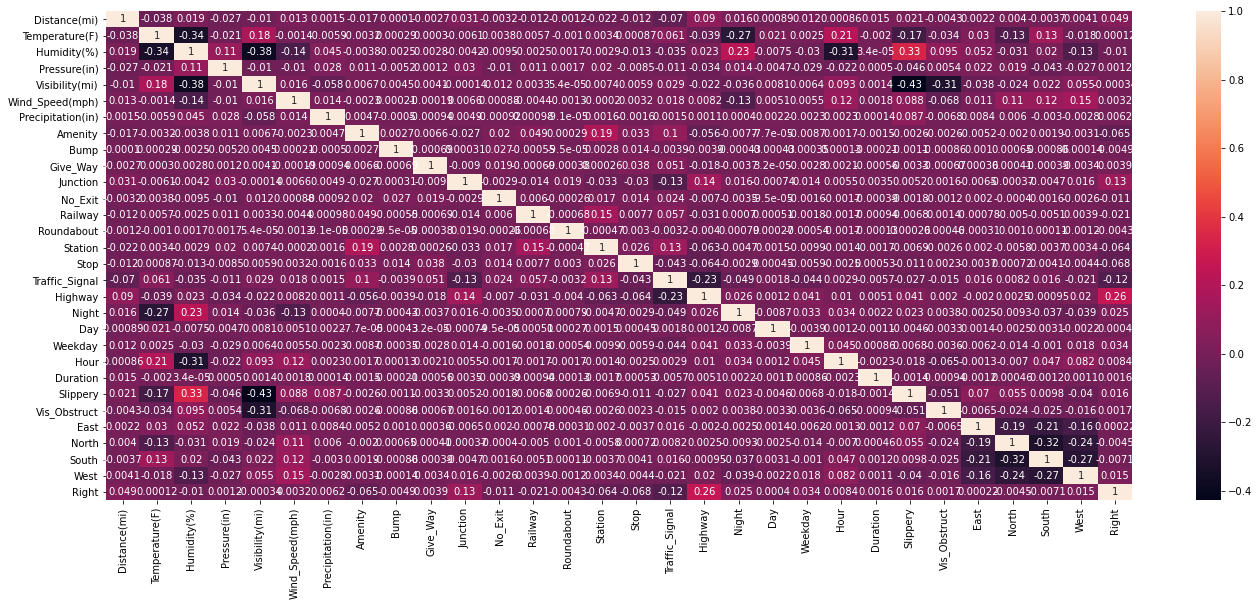

In [22]:
plt.figure(figsize = (23,9))
sns.heatmap(X.corr(), annot = True)

In [23]:
# # Deletes any factors that have corr higher than 0.3 or lower than -0.3
# colsToDelete = []
# corrMatrix = X.corr()
# for i in corrMatrix.index:
#     for j in corrMatrix.columns:
#         if( abs(corrMatrix[i][j])>=0.2 and i!=j ):
#             colsToDelete.append(i)
# colsToDelete = list( pd.Series(colsToDelete).unique() )
# x_c = X.drop(colsToDelete, axis=1)
# # x_c.info()

In [24]:
# plt.figure(figsize = (23,9))
# sns.heatmap(x_c.corr(), annot = True)

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

# Scale the Data : 
Only want to scale the numerical values. Categorical variables need to be removed before the scaling can begin.

In [26]:
X_categorical = X.drop(['Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)',
               'Wind_Speed(mph)','Precipitation(in)','Duration'], axis = 1)
X_to_scale = X.drop(['Amenity','Bump','Give_Way','Junction','No_Exit','Railway','Roundabout',
                 'Station','Stop','Traffic_Signal','Highway','Day','Night','Slippery','Vis_Obstruct',
                 'Right','East','West','North','South'], axis = 1)
red_X_categorical = red_X.drop(['Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)',
               'Wind_Speed(mph)','Precipitation(in)','Duration'], axis = 1)
red_X_to_scale = red_X.drop(['Amenity','Bump','Give_Way','Junction','No_Exit','Railway','Roundabout',
                 'Station','Stop','Traffic_Signal','Highway','Day','Night','Slippery','Vis_Obstruct',
                 'Right','East','West','North','South'], axis = 1)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_scale)
red_X_scaled = scaler.fit_transform(X_to_scale)

In [28]:
X_scaled = pd.DataFrame(X_scaled)
red_X_scaled = pd.DataFrame(X_scaled)
fs_X = pd.concat([X_scaled, X_categorical], axis = 1, join = 'inner')
rs_X = pd.concat([red_X_scaled, red_X_categorical], axis = 1, join = 'inner')

fs_X = full scaled data matrix 
rs_X = reduced scaled data matrix

# Regression Approach

# Full Covariate Model

## Model 1: 
All Covariates Used
Month, No_Exit, Variable are NOT considered significant

## Model 2: 
No Change in Significant values. High chance of Multicollinearity

## Overfitting Problem:
Decided to try to reduce the number of factors by limiting the Correlation values
abs(corr(x,y)) <= 0.3
Reduced the number of covariates to 23, but no significant increase in R^2

By removing intercet, adj R^2 = .952

## Model 3: 
Removed East, West, and Precipitation
Scaled the values to reduce the large differences in values

Cauesed a problem with the regression model

## Model 4:
Checked VIF to remove the multicollinearity problem
Removed Right, Day, Pressure(in)

In [29]:
model = sm.OLS(y,X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:               Severity   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          2.457e+06
Date:                Tue, 11 May 2021   Prob (F-statistic):                        0.00
Time:                        11:26:11   Log-Likelihood:                     -2.6389e+06
No. Observations:             3513617   AIC:                                  5.278e+06
Df Residuals:                 3513587   BIC:                                  5.278e+06
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

# Reduced Model - Not Scaled
Dropped Bump, Vis_Obstruct, and West because they were insignificant

OLS Regression Results                                

Dep. Variable:               Severity   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          1.025e+06
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        14:50:27   Log-Likelihood:                     -1.1094e+06
No. Observations:             1435573   AIC:                                  2.219e+06
Df Residuals:                 1435546   BIC:                                  2.219e+06
Df Model:                          27                                                  

# Reduced Scaled Model
Very low R-squared. Not good at predicting the response variable

Dep. Variable:               Severity   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     6687.
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        13:48:22   Log-Likelihood:            -1.0984e+06
No. Observations:             1435573   AIC:                         2.197e+06
Df Residuals:                 1435542   BIC:                         2.197e+06
Df Model:                          30                                         
Covariance Type:            nonrobust   

# Full Model : Not Scaled
Very High R-Squared. Great at predicting the response variable.

Dep. Variable:               Severity   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          2.304e+06
Date:                Wed, 07 Apr 2021   Prob (F-statistic):                        0.00
Time:                        23:35:20   Log-Likelihood:                     -2.6388e+06
No. Observations:             3513617   AIC:                                  5.278e+06
Df Residuals:                 3513585   BIC:                                  5.278e+06
Df Model:                          32                                                  
Covariance Type:            nonrobust 

# Calculate the VIF to check for Multicollinearity
1	16.151832	Temperature(F)
2	14.786851	Humidity(%)
3	81.084869	Pressure(in)
4	16.797855	Visibility(mi)

In [30]:
# # VIF for Covariates
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate the VIF for each explanatory variable
# vif = pd.DataFrame()
# vif['VIF'] = [variance_inflation_factor(red_X.values, i) for i in range(red_X.shape[1])]
# vif['variable'] = red_X.columns

# # Display VIF for each explanatory variable
# vif

# VIF for the Reduced X Model
#   	VIF	        Variable 
# 1 	17.427359	Temperature(F)
# 2 	17.256245	Humidity(%)
# 3 	76.947553	Pressure(in)
# 4 	13.729607	Visibility(mi)
# 5 	3.702511	Wind_Speed(mph)
# 18	4.252690	Day
# 20	7.430684	Hour
# 26	5.974539	Right

# New VIF after Removing Values > 10
#       VIF         Variable
#  1	7.998885	Visibility(mi)
#  2	3.561250	Wind_Speed(mph)
# 17	6.049782	Hour
# 23	5.189984	Right

In [31]:
rs_X = red_X.drop(["Temperature(F)", "Humidity(%)", "Pressure(in)"], axis = 1)

# Application of Nueral Network Design

Each node in the Hidden Layers is a function of each previous node
in the previous layer. This builds a cascading connection which eventually
leads to the final 4 outputs


a = activation level ( 0, 1)
W = weight of node
b = bias ( activation level )
a.ij = reLu( W.ij * a.ij-1 + b.ij )    where i = node index, j = layer index


reLU function = max ( 0, a) 
* only becomes activated once a.ij surpasses 0

In [32]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [33]:
# from sklearn import svm
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
# from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score
# from sklearn.preprocessing import label_binarize

In [34]:
# y_raw = df['Severity']
# Use red_y instead
# This turns y into a list of dummy variables for each input [1, 2, 3, 4]
encoder = LabelEncoder()
encoder = encoder.fit(red_y)
y = encoder.transform(red_y)
y = to_categorical(y)

In [37]:
# Full Model Version train = [2810893, 32], test = [702724, 4]
x_tr, x_ts, y_tr, y_ts = train_test_split(rs_X, y, test_size = 0.2, random_state =100)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min',
                           verbose = 1, patience = 5)

In [45]:
nn = Sequential()
# Input Layer
nn.add(Dense(27, activation = 'relu', input_shape = (27,)))
# Hidden Layers 
nn.add(Dense(20, activation = 'relu'))
nn.add(Dense(20, activation = 'relu'))
# Output Layer
nn.add(Dense(4, activation = 'softmax'))
# Compiling the Model     
nn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Options for Optimizers : Stochastic Gradient Descent (SGD), ADAM, & RMSprop
# loss = 'binary_crossentropy' for binary models
# MSE = Metric for Regression approach

In [42]:
nn.fit(x_tr, y_tr, epochs = 100,
      # callbacks = [early_stop],
          batch_size = 100, verbose = 1, validation_data = (x_ts, y_ts))
# [32, 20, 10, 4] : loss = 0.6496 acc = 0.7330
# [32, 20, 15, 10, 4] : loss = 0.5495 acc = 0.7658
# [32, 20, 20, 20, 4] : loss = .6 acc = 7.550
# [32, 25, 18, 11, 4] : loss: 0.5450 - accuracy: 0.7675 - epoch = 65 

Epoch 1/100
11485/11485 [==============================] - 15s 1ms/step - loss: 0.8650 - accuracy: 0.7030 - val_loss: 0.6705 - val_accuracy: 0.7299
Epoch 2/100
11485/11485 [==============================] - 14s 1ms/step - loss: 0.8092 - accuracy: 0.7243 - val_loss: 0.6339 - val_accuracy: 0.7326
Epoch 3/100
11485/11485 [==============================] - 14s 1ms/step - loss: 0.6421 - accuracy: 0.7332 - val_loss: 0.6313 - val_accuracy: 0.7330
Epoch 4/100
11485/11485 [==============================] - 14s 1ms/step - loss: 0.6251 - accuracy: 0.7377 - val_loss: 0.6220 - val_accuracy: 0.7392
Epoch 5/100
11485/11485 [==============================] - 15s 1ms/step - loss: 0.6180 - accuracy: 0.7414 - val_loss: 0.6154 - val_accuracy: 0.7436
Epoch 6/100
11485/11485 [==============================] - 15s 1ms/step - loss: 0.6176 - accuracy: 0.7419 - val_loss: 0.6121 - val_accuracy: 0.7445
Epoch 7/100
11485/11485 [==============================] - 14s 1ms/step - loss: 0.6125 - accuracy: 0.7433 - val_

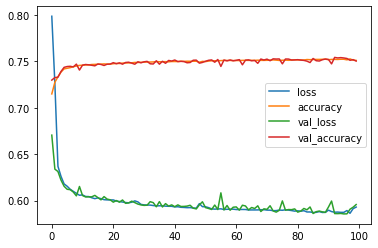

In [43]:
nn_loss = pd.DataFrame(nn.history.history)
nn_loss.plot()

In [44]:
scores = nn.evaluate(x_ts, y_ts)
print(scores)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8973/8973 [==============================] - 7s 724us/step - loss: 0.5957 - accuracy: 0.7504
[0.5956653952598572, 0.7503752708435059]


# Model Tuning:

[0.7725, 0.6755] are loss and accuracy from model : [17, 20, 10, 4] Dropout = 0.4
Based on Reduced Covariate Model. 

[0.6196, 0.7019] are loss and accuracy from model : [24, 20, 10, 4], dropout = 0.3
Based on Full Covariate Model.

[0.5922, 0.7513] are loss and accuracy from model : [32, 20, 10, 4], dropout = 0.1
Based on Full Covariate Model.

In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# seed = 100
# np.random.seed(seed)

# kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
# for train, test in kfold.split(x_train_nn, y_train_nn):
#     model.add(Dense(19, activation = 'relu', input_shape = (19,)))         
#     model.add(Dropout(rate = 0.4))

#     model.add(Dense(20 , activation = 'relu'))
#     model.add(Dropout(rate = 0.4))

#     model.add(Dense(10 , activation = 'relu'))
#     model.add(Dropout(rate = 0.4))

#     model.add(Dense(4, activation = 'softmax'))
#     model.compile(loss = 'categorical_crossentropy',
#               optimizer = 'adam', metrics = ['accuracy'])

# ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.


# Neural Network Grid Search : 

In [ ]:
# MODEL 1 APPROACH
layer1 = [10, 20, 30]
layer2 = [5, 10, 15]
drop = [0.1, 0.2, 0.3, 0.4, 0.5]

for a in layer1:
    for b in layer2:
        for d in drop:
            model_full = Sequential()

            # change the density number and input shape to mactch input data
            model_full.add(Dense(32, activation = 'relu', input_shape = (32,)))          
            model_full.add(Dropout(rate = d))

            model_full.add(Dense(a , activation = 'relu'))
            model_full.add(Dropout(rate = d))

            model_full.add(Dense(b , activation = 'relu'))
            model_full.add(Dropout(rate = d))

            model_full.add(Dense(4, activation = 'softmax'))

            model_full.compile(loss = 'categorical_crossentropy',
                               optimizer = 'adam', metrics = ['accuracy'])

            model_full.fit(x_tr, y_tr, epochs = 5, batch_size = 150)
            
            scores = model_full.evaluate(x_ts, y_ts)
            loss = score_list.append(scores)
            
            

### Record of Validation Loss and Accuracy :
Record of the Accuracy and Loss Scores on the Testing Data

10 - 20 - 30
5 - 10 - 15
0.1 0.2 0.3 0.4 0.5

#### loss: 0.5976 - accuracy: 0.7521
loss: 0.6354 - accuracy: 0.7491
loss: 0.6531 - accuracy: 0.7467
loss: 0.6531 - accuracy: 0.7467
loss: 0.6833 - accuracy: 0.7259

#### loss: 0.5899 - accuracy: 0.7527
loss: 0.6150 - accuracy: 0.7486
loss: 0.7725 - accuracy: 0.6755
loss: 0.6472 - accuracy: 0.7451
loss: 0.7726 - accuracy: 0.6755

loss: 0.7728 - accuracy: 0.6755
loss: 0.6269 - accuracy: 0.7262
#### loss: 0.6401 - accuracy: 0.7446
loss: 0.7725 - accuracy: 0.6755
loss: 0.7725 - accuracy: 0.6755

loss: 0.7725 - accuracy: 0.6755
loss: 0.6152 - accuracy: 0.7471
#### loss: 0.6351 - accuracy: 0.7474
loss: 0.6497 - accuracy: 0.7469
loss: 0.6974 - accuracy: 0.6755

#### loss: 0.5855 - accuracy: 0.7508
loss: 0.6137 - accuracy: 0.7465
loss: 0.6222 - accuracy: 0.7476
loss: 0.6512 - accuracy: 0.7443
loss: 0.7092 - accuracy: 0.7042

In [46]:
model_full = Sequential()

# change the density number and input shape to mactch input data
model_full.add(Dense(32, activation = 'relu', input_shape = (32,)))          
model_full.add(Dropout(rate = 0.2))
model_full.add(Dense(10 , activation = 'relu'))
model_full.add(Dropout(rate = 0.2))
model_full.add(Dense(10 , activation = 'relu'))
model_full.add(Dropout(rate = 0.2))
model_full.add(Dense(4, activation = 'softmax'))
model_full.compile(loss = 'categorical_crossentropy',
                   optimizer = 'adam', metrics = ['accuracy'])

model_full.fit(x_tr, y_tr, epochs = 200, batch_size = 150)
            
scores = model_full.evaluate(x_ts, y_ts)
loss = score_list.append(scores)

Epoch 1/200


ValueError: in user code:

    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\skhou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 32 but received input with shape (None, 27)


In [ ]:
scores = model_full.evaluate(x_ts, y_ts)
print(scores)

In [ ]:
nn_loss = pd.DataFrame(model_full.history.history)
nn_loss.plot()

In [ ]:
# # MODEL 2 APPROACH
# layer1 = [10, 20]
# layer2 = [5, 7, 10]
# for a in layer1:
#     for b in layer2:
#             model_full = Sequential()
            
#             # change the density number and input shape to mactch input data
#             model_full.add(Dense(32, activation = 'relu', input_shape = (32,)))          
#             model_full.add(Dropout(rate = 0.2))

#             model_full.add(Dense(a , activation = 'relu'))
#             model_full.add(Dropout(rate = 0.2))

#             model_full.add(Dense(b , activation = 'relu'))
#             model_full.add(Dropout(rate = 0.2))

#             model_full.add(Dense(4, activation = 'softmax'))

#             model_full.compile(loss = 'categorical_crossentropy',
#                                optimizer = 'adam', metrics = ['accuracy'])
            
#             # Made small changes to the batch size to see if there were any distinctions
#             model_full.fit(x_tr, y_tr, epochs = 10, batch_size = 75,
#                            callbacks = [early_stop], verbose = 1, 
#                            validation_data = (x_ts, y_ts))

#             # Plot the Loss and Accuracy for each combination
#             nn_loss = pd.DataFrame(model_full.history.history)
#             nn_loss.plot()

#### BEST RESULT 
[32, 20, 10, 4]
Epoch 9/10
37479/37479 [==============================] - 61s 2ms/step - loss: 0.6274 - accuracy: 0.7396 - val_loss: 0.6100 - val_accuracy: 0.7467
Epoch 00009: early stopping

## Balancing the Training Data

May help to reduce the run-time of the model as well as giving better accuracy

In [47]:
XY = df.drop(['MapQuest-Bing','Start_Lat','Start_Lng','MapQuest','County_State'], axis=1)
# bal = bal.astype("float")

In [48]:
# This creates a sample from each of the different groups of Severity
g = XY.groupby('Severity')
bal = g.apply(lambda x: x.sample(g.size().min()-1).reset_index(drop=False))

In [49]:
XY['Severity'].value_counts()za
bal['Severity'].value_counts()

2    2373210
3     998913
4     112320
1      29174
Name: Severity, dtype: int64

4    29173
3    29173
2    29173
1    29173
Name: Severity, dtype: int64

In [50]:
# df = pd.DataFrame({'a':np.random.randn(5)})
# df
# df.loc[~df.index.isin(t)]

t = bal['index']
XY = pd.DataFrame(XY)
Test = XY.loc[~XY.index.isin(t)]
Train = XY.loc[XY.index.isin(t)]

In [51]:
yb_ts = Test['Severity']
xb_ts = Test.drop(['Severity'], axis = 1)
yb_tr = Train['Severity']
xb_tr = Train.drop(['Severity'], axis = 1)

In [52]:
# This turns y into a list of dummy variables for each input [1, 2, 3, 4]
encoder = LabelEncoder()
encoder = encoder.fit(yb_tr)
yb_tr = encoder.transform(yb_tr)
yb_tr = to_categorical(yb_tr)

encoder = LabelEncoder()
encoder = encoder.fit(yb_ts)
yb_ts = encoder.transform(yb_ts)
yb_ts = to_categorical(yb_ts)

This data doesn't need to be set as training or testing. The smaller sample sizes from df give the "training data" and the testing data will be whatever observations aren't used in the training.

In [53]:
nn2 = Sequential()

# change the density number and input shape to mactch input data
nn2.add(Dense(32, activation = 'relu', input_shape = (32,)))         
nn2.add(Dropout(rate = 0.1))

nn2.add(Dense(20, activation = 'relu'))
nn2.add(Dropout(rate = 0.1))

nn2.add(Dense(20, activation = 'relu'))
nn2.add(Dropout(rate = 0.1))

nn2.add(Dense(20, activation = 'relu'))
nn2.add(Dropout(rate = 0.1))

nn2.add(Dense(4, activation = 'softmax'))

nn2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [54]:
nn2.fit(xb_tr, yb_tr, epochs = 100,
          batch_size = 100, verbose = 1, validation_data = (xb_ts, yb_ts))
# , validation_data = (Xb_t, yb_t)

Epoch 1/100
1167/1167 [==============================] - 31s 26ms/step - loss: 1.7080 - accuracy: 0.3658 - val_loss: 1.3101 - val_accuracy: 0.3218
Epoch 2/100
1167/1167 [==============================] - 23s 20ms/step - loss: 1.1764 - accuracy: 0.4639 - val_loss: 1.2229 - val_accuracy: 0.2609
Epoch 3/100
1167/1167 [==============================] - 24s 20ms/step - loss: 1.1043 - accuracy: 0.4956 - val_loss: 1.2159 - val_accuracy: 0.3141
Epoch 4/100
1167/1167 [==============================] - 24s 20ms/step - loss: 1.0578 - accuracy: 0.5219 - val_loss: 1.1767 - val_accuracy: 0.3268
Epoch 5/100
1167/1167 [==============================] - 24s 21ms/step - loss: 1.0291 - accuracy: 0.5423 - val_loss: 1.1056 - val_accuracy: 0.3137
Epoch 6/100
1167/1167 [==============================] - 24s 21ms/step - loss: 0.9957 - accuracy: 0.5620 - val_loss: 1.1301 - val_accuracy: 0.3158
Epoch 7/100
1167/1167 [==============================] - 24s 21ms/step - loss: 0.9668 - accuracy: 0.5848 - val_loss: 1

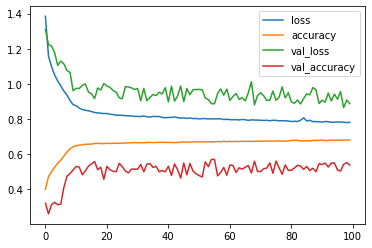

In [55]:
nn_loss = pd.DataFrame(nn2.history.history)
nn_loss.plot()

In [ ]:
# from sklearn.neural_network import MLPClassifier
# # Multi Layer Perceptron Classifier

# clf = MLPClassifier(solver = 'adam', activation = 'relu', alpha = 0.0001, 
#                    hidden_layer_sizes = (20,10), random_state = 100, verbose = 1)

In [ ]:
# clf.fit(x_tr, y_tr)

In [ ]:
# Model output shape
# model.output_shape

# Model summary
# model.summary()

# Model config
# model.get_config()

# List all weight tensors 
# model.get_weights()

In [ ]:
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
# from IPython.display import Image
# import pydotplus

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,
#       filled=True, rounded=True,
#       special_characters=True,feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('Pima_diabetes_Tree.png')
# Image(graph.create_png())

In [ ]:
# Multi-Classification : K = 4 
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(n_estimators = 100)
# rfc.fit(x_train, y_train)

## Application of the Random Forest Design : 

Creates an array of decision trees based on the splitting the data into each of the 4 categories by spliting the variables in the training data randomly. Then, using the accuracy, the tree is pruned and remodeled.

In [ ]:
# Random Forest Classifier : 
y_rfc = df['Severity']

# Split into train and test
x_train_rfc, x_test_rfc, y_train_rfc, y_test_rfc = train_test_split(
    X,y_rfc, test_size = 0.2, random_state = 101)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 50, random_state = 101, n_jobs = -1)
clf = clf.fit(x_train_rfc, y_train_rfc)
y_pred_rfc = clf.predict(x_test_rfc)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test_rfc, y_pred_rfc))
print('\n')
print(classification_report(y_test_rfc, y_pred_rfc))
print('\n')
print(accuracy_score(y_test_rfc,y_pred_rfc))